# NLP_GoingDeeper | P05.Transformer_Translation_Kor2Eng
---
- 한국어 문장을 입력으로 하여 영어로 번역된 문장을 출력하는 번역기를 만들어봅니다. 

- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)에서 제공하는 데이터셋을 활용합니다.

In [1]:
# ! ln -s ~/data ~/aiffel/GoingDeeper/DATA/transformer/data

In [2]:
#- 나눔글꼴 설치
! sudo apt -qq -y install fonts-nanum

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [3]:
#- SentencePiece 설치

! pip install sentencepiece

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import matplotlib as mpl 
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/user/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

In [5]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import sentencepiece as spm

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from tqdm import tqdm
from tqdm import tqdm_notebook
import random


print(tf.__version__)

2.4.1


In [6]:
data_dir = os.getenv('HOME')+'/aiffel/GoingDeeper/DATA/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

In [7]:
with open(kor_path, "r") as f: kor = f.read().splitlines()
with open(eng_path, "r") as f: eng = f.read().splitlines()
print("Data Size:({},{})".format(len(kor), len(eng)))
print("Example:")

cnt = 0
for ko, en in zip(kor, eng):
    print(f">>\n한국어 : {ko}\n영어 : {en}\n")
    cnt += 1
    if cnt == 5:
        break

Data Size:(94123,94123)
Example:
>>
한국어 : 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
영어 : Much of personal computing is about "can you top this?"

>>
한국어 : 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
영어 : so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.

>>
한국어 : 그러나 이것은 또한 책상도 필요로 하지 않는다.
영어 : Like all optical mice, But it also doesn't need a desk.

>>
한국어 : 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
영어 : uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.

>>
한국어 : 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
영어 : Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror atta

# 2. 데이터 정제 및 토큰화 
### 1) 중복데이터 제거
- set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거합니다. 
- 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [8]:
# 데이터 정제 및 토큰화
def clean_corpus(kor, eng):
    assert len(kor) == len(eng)
    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

In [9]:
cleaned_corpus = clean_corpus(kor, eng)
len(cleaned_corpus)

78968

### 2) 정제함수 정의

- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다.
- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [10]:
def preprocess_sentence(sentence):
    sentence = sentence.lower() #- 소문자 변환
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence) #- 알파벳, 문장부호, 한글 이외는 제거
    sentence = re.sub(r'[" "]+', " ", sentence) #- 여러개의 공백은 하나의 공백으로 바꾸기
    sentence = sentence.strip() #- 양쪽 공백 제거
    return sentence

### 3) 토큰화
- 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다. 
- 토큰화에는 [SentencePiece](https://github.com/google/sentencepiece)를 사용합니다. 
    - generate_tokenizer() 함수를 정의하여 최종적으로 ko_tokenizer와 en_tokenizer를 얻습니다. 
    - en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.
    - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
    - 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
    - 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
        - \<PAD> : 0 / \<BOS\> : 1 / \<EOS\> : 2 / \<UNK\> : 3
- [spm의 입력은 txt로 넣어야 합니다.](https://lovit.github.io/nlp/2018/04/02/wpm/)

In [11]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, model_type='unigram', vocab_size=32000, lang="ko"): 
    
    input_file = f'{lang}_spm_input.txt'

    with open(input_file, 'w', encoding='utf-8') as f:
        for sent in corpus:
            f.write('{}\n'.format(sent))
        
    sp_model_root='sentencepiece'
    if not os.path.isdir(sp_model_root): os.mkdir(sp_model_root)
    
    prefix = 'tokenizer_%s_%s' % (lang,model_type+str(vocab_size))
    prefix = os.path.join(sp_model_root, prefix) # 저장될 tokenizer 모델에 붙는 이름
    pad_id=0
    bos_id=1 #<start> token을 1으로 설정
    eos_id=2 #<end> token을 2으로 설정
    unk_id=3 #<unknown> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set 
    # model_type = model_type # Choose from unigram (default), bpe, char, or word
    input_argument = '--input=%s --pad_id=%s --bos_id=%s --eos_id=%s --unk_id=%s --model_prefix=%s --vocab_size=%s --character_coverage=%s --model_type=%s'
    cmd = input_argument%(input_file, pad_id, bos_id, eos_id, unk_id, prefix, vocab_size, character_coverage, model_type)
                      
    spm.SentencePieceTrainer.Train(cmd)
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')
    
    return tokenizer

In [12]:
cleaned_corpus[1]

('나와즈 샤리프 전 총리가 부토 전 총리 암살 후 조문을 위해 병원을 방문하자 병원 안은 혼잡해졌다.',
 'Chaos erupted at the hospital when former Prime Minister Nawaz Sharif arrived to pay his respects to Bhutto less than three hours after her death.')

In [13]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 32000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0],pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, 'unigram', SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, 'unigram', TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [14]:
ko_test_txts = ['세계기상기구는 “코로나19에 따른 경제 활동 둔화로 탄소 배출이 일시적으로 줄었지만, 대기 중 이산화탄소 농도에 뚜렷한 영향을 주지 못했다”고 설명했다.','기후변화 대응·적응에 필요한 재원 분담 과정에서 나타나는 선진국과 개발도상국의 이견도 오래 묵은 논쟁거리다.']
en_test_txts = ['Democrats, including President Biden, are lobbying for Senator Joe Manchin’s support, knowing he is a crucial swing vote on their domestic agenda.','The contest to fill a vacant State House seat in South Texas has exposed the vulnerabilities of a Democratic stronghold.']


In [15]:
def testSP(sp, txts):
    tokens_list = []
    for txt in txts:
        tokens = sp.encode_as_pieces(txt)
        #ids = sp.encode_as_ids(txt)
        tokens_list.append(tokens)
    return tokens_list

In [16]:
testSP(ko_tokenizer, ko_test_txts)

[['▁세계',
  '기',
  '상',
  '기구',
  '는',
  '▁',
  '“',
  '코',
  '로',
  '나',
  '19',
  '에',
  '▁따른',
  '▁경제',
  '▁활동',
  '▁둔화',
  '로',
  '▁탄소',
  '▁배출',
  '이',
  '▁일시적',
  '으로',
  '▁줄',
  '었지만',
  ',',
  '▁대기',
  '▁중',
  '▁이산화탄소',
  '▁농도',
  '에',
  '▁뚜렷',
  '한',
  '▁영향',
  '을',
  '▁주지',
  '▁못했다',
  '”',
  '고',
  '▁설명했다',
  '.'],
 ['▁기후변화',
  '▁대응',
  '·',
  '적',
  '응',
  '에',
  '▁필요한',
  '▁재원',
  '▁분담',
  '▁과정에서',
  '▁나타나',
  '는',
  '▁선진국',
  '과',
  '▁개발도상국',
  '의',
  '▁이견',
  '도',
  '▁오래',
  '▁묵',
  '은',
  '▁논쟁거리',
  '다',
  '.']]

In [17]:
testSP(en_tokenizer, en_test_txts)

[['<s>',
  '▁',
  'D',
  'em',
  'ocrats',
  ',',
  '▁including',
  '▁',
  'P',
  'res',
  'ident',
  '▁',
  'B',
  'iden',
  ',',
  '▁are',
  '▁lobby',
  'ing',
  '▁for',
  '▁',
  'S',
  'en',
  'ator',
  '▁',
  'J',
  'o',
  'e',
  '▁',
  'M',
  'an',
  'chi',
  'n',
  '’',
  's',
  '▁support',
  ',',
  '▁knowing',
  '▁he',
  '▁is',
  '▁a',
  '▁crucial',
  '▁swing',
  '▁vote',
  '▁on',
  '▁their',
  '▁domestic',
  '▁agenda',
  '.',
  '</s>'],
 ['<s>',
  '▁',
  'T',
  'he',
  '▁contest',
  '▁to',
  '▁fill',
  '▁a',
  '▁vacant',
  '▁',
  'S',
  'tate',
  '▁',
  'H',
  'ouse',
  '▁seat',
  '▁in',
  '▁',
  'S',
  'out',
  'h',
  '▁',
  'T',
  'ex',
  'as',
  '▁has',
  '▁exposed',
  '▁the',
  '▁vulnerabilities',
  '▁of',
  '▁a',
  '▁',
  'D',
  'e',
  'mo',
  'cratic',
  '▁stronghold',
  '.',
  '</s>']]

### 4) 데이터 선별
- 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축합니다. 
- 이후 텐서 enc_train 과 dec_train 으로 변환합니다. 

In [18]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

#- 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50 :
        src_corpus.append(src)
        tgt_corpus.append(tgt)

#- 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

# 3. 모델 설계


In [19]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)  
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
    
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        return out, attentions 
    
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)
        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding된 입력을 head의 수로 분할하는 함수
        
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

In [21]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)
        
    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
        return out

In [22]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        #- Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        #- Position-Wise Feed Forward Network
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [23]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        #- Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual
        
        #- Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        #- Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [24]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns

In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

In [26]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size,
                 pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        #- 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        #- 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        #- 6. Dropout 정의
        self.do = tf.keras.layers.Dropout(dropout)
        
        #- 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        #- 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        #- 5. Shared Weights
        self.shared = shared
        
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        #- Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        #- Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        #- Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        #- Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [27]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

# 4. 훈련
### 1) 모델 선언
2 Layer를 가지는 Transformer를 선언합니다. (하이퍼파라미터는 자유롭게 조절) 

In [28]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

### 2) Learning Rate Scheduler
- 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언합니다. 

In [29]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [30]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

### 3) Loss 함수 정의
- Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [31]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 4) train_step 함수 정의
- 입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다. 

In [32]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 5) 학습 진행
- 매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 기록합니다. 

- 예문
    1. 오바마는 대통령이다.
    2. 시민들은 도시 속에 산다.
    3. 커피는 필요 없다.
    4. 일곱 명의 사망자가 발생했다.
    5. 투표는 시민의 권리이다.
    6. 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
    7. 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
    8. 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
    

In [33]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [34]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [35]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a obama campaign.
Input: 시민들은 도시 속에 산다.
Predicted translation: the storm is a largely to the storm.
Input: 커피는 필요 없다.
Predicted translation: i don t get a good.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll were killed in the hospital.
Input: 투표는 시민의 권리이다
Predicted translation: the white house is a lot of the white house of the country s economic party.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the company is expected to be a new york, and the storm, the company, the company, the company.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the company is expected to be a new record of the u.s. state, a new york, a new york official said.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: the year old was a million in the international group of the international group of the international group.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first thing
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of jesus is a simple.
Input: 커피는 필요 없다.
Predicted translation: it is not clear how it did not need to do.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is a vote for the vote.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the animal is a rarely known as a precautionary of the year old drug, the official said.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the energy policy is a serious problem, the u.s. and the nation s top policy, the u.s. and the nation s top policy.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is a few years ago, the international community, the international agency said.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s lead obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a great city.
Input: 커피는 필요 없다.
Predicted translation: no need to be no need for no.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll was reported.
Input: 투표는 시민의 권리이다
Predicted translation: the right to the right rights of rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the body is the largest ever known as the result of the population, which is a significant risk of developing the population.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the energy analyst s energy agency says the u.s.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is a few years ago, park said.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a green mountain.
Input: 커피는 필요 없다.
Predicted translation: there is no reason to be a single person.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths were reported.
Input: 투표는 시민의 권리이다
Predicted translation: the voting rights is right now.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the body of the art model is the largest city of dengue related to the disease, the university of georgia.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the white house says it s a long time for the white house, which is a product for the energy giant, which is a product.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is to be jailed in the world, and the international community is a terrorist organization.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is now.
Input: 시민들은 도시 속에 산다.
Predicted translation: the town is the mountain.
Input: 커피는 필요 없다.
Predicted translation: no one has been drinking.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen people were killed tuesday.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is a choice.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the same sex is the largest and loss of blood related to the suffering of the disease.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the energy department is the largest building in the united states, and we saw that particular time in the long term.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is accused of plotting to take the global resistance to the global economic meltdown.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: the iraqis are the enemy.
Input: 커피는 필요 없다.
Predicted translation: there is no need for anyone.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died on saturday.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is a civil rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: it is the birthplace of the suffering of the disease, the geese, and the deaths of the suffering.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: biofuels is often used by a massive amount of energy giants could not be used for a possibility of a long term.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is accused of being a global development that led the global tourism organization.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is looking for ways
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens do well well in the city.
Input: 커피는 필요 없다.
Predicted translation: no one noticed cents.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported saturday.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is the right rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking habits of medicine, drinking and seconds, the whole disease has been closed by the suffering of the suffering of the suffering of the suffering of the suffering of the brain, and a low turnout.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: i saw the possibility of a massive u.s. massive energy being a massive coal transition team, and i thinks it is.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is leading a famous for agricultural inflation, with percent of the world s leading fema

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are well in their s.
Input: 커피는 필요 없다.
Predicted translation: it s clear in the competition.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is the right to rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking alcohol is a result of drinking water, which is hugely known as burma.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the possibility of a highly competitive blanket, such as colored use, probably the energy administration to use even an early spring.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is being criticized for being founded by the international soccer federation for the international draw.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens protested city to the city.
Input: 커피는 필요 없다.
Predicted translation: it s not clear how easy a should take.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died on monday.
Input: 투표는 시민의 권리이다
Predicted translation: the only citizens of the vote.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: it is difficult for the years of probation from what happened, defeat finance minister kim man affected by the investigation of the cause of the suffering of the suffering of the known term.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: you can saw germany as a de use of the bush administration, such as having a particular thing about it.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is out in for the event until he foundeds , park chang said.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens protested their enemy urban moving.
Input: 커피는 필요 없다.
Predicted translation: no one got to taiwan.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died on thursday.
Input: 투표는 시민의 권리이다
Predicted translation: the only citizens are rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking gear up to million people, known as daniel day festival, it says.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: i ve brought them to taiwan, and possibly angry that particular.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is accused of hosting international peace times before joining the international community in .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is now in the hands of his family.
Input: 시민들은 도시 속에 산다.
Predicted translation: handful of the city san diego.
Input: 커피는 필요 없다.
Predicted translation: no one got to taiwan.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths were the seven deaths.
Input: 투표는 시민의 권리이다
Predicted translation: the right political people s rights
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: organizers of the million drinking zoo known as must suspected million in peace become rehabilitation s agency.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: you can pro creating a more common look like this, even more than what it used in congress.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is being accused of being a soccer video of the international community, leading worldwide attention.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens give us they san antonio.
Input: 커피는 필요 없다.
Predicted translation: there s no need for anything.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths, seven people were killed.
Input: 투표는 시민의 권리이다
Predicted translation: the only voted the rights of principles
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: it is obvious that known for the deaths of these facilities, going known as minister for most of the government, and vice president dick cheney.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: you can use it by tv, and joe biden as long as the administration s, such as detroit, cnn.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is hosting a global peace campaign event that led by former colombian mayor andrew suffering himself in the international monetary policy.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is moving into a single day.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens give up their mountain san francisco
Input: 커피는 필요 없다.
Predicted translation: no one should be taking a prohibit.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were killed on saturday.
Input: 투표는 시민의 권리이다
Predicted translation: the only citizens include the rights of citizens.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: it is obvious that between prone gul, discussion of the disease, and stacy fisher, the report spinalito party, which includes most of the blamed on drinking tae deaths.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: you saw a steady stream of mine defi you work more powers, like that, mine often ticket sales.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is a few years ago that he launched presidency, a worldwide economy in .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is holding a service in the south.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are sead in the san they know their green.
Input: 커피는 필요 없다.
Predicted translation: there s no need to pay anything from there, he s no need to sit down and august .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died on thursday.
Input: 투표는 시민의 권리이다
Predicted translation: the same as citizens rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: it is known that of the million villagers, as yet, known as worries, could be responsible for disease complete.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: itself the united states accuses the democrats of using a particular prison united states in the past hour, energy, crowd like them, used by a question of u.s. financial intelligence task force to use his own use.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted trans

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is holding everywhere.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens give to the city they leaves the san f th mountain in the san for their green mountain in the northeast san f .
Input: 커피는 필요 없다.
Predicted translation: there s no need to reopen.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were the seven people.
Input: 투표는 시민의 권리이다
Predicted translation: the only citizens can be condemned.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: it is known that of the million buddhist jo individuals, known as ambassador for the rate of choice.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: instead electricity, red pepper sprayeed the administration out, often say.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is a leading member of the international globe for years before park vowed to be a british promote.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the iraqis are moving in the city.
Input: 커피는 필요 없다.
Predicted translation: it s no conservation. but the eggs and coffee need to worry for anything.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were the seven deaths.
Input: 투표는 시민의 권리이다
Predicted translation: the only vote is a citizens.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the main drinking is tightly high result of the deaths, and many experts believe the dangers of known as park chung hee.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: you can pro creating a more basis for long term government, possibly often the use of biofuels as much as percent of u.s. government, for the first time.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is out in the international game of former opponent who famous for the international comm

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are thought to have their san jose.
Input: 커피는 필요 없다.
Predicted translation: no one has to refrain from drinking coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths are the seven.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is a civil rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the leader of the million people, known as sun il divo and rates told a complete cast group.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: you can pro energye possibly make a particular customer, particularly often like having a energy plan, even with a small number of u.s. congress.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is hosting a global peace transition team, she thinks that international studies have protected them.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is two president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens are emerged from the city.
Input: 커피는 필요 없다.
Predicted translation: the single season your swiss did doctor need to stop.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were killed on friday.
Input: 투표는 시민의 권리이다
Predicted translation: the only citizens are equal.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the extended crime for nearly million people convicted of kidnapping, and sometimes assassination attempt.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: instead, the energy efficient economy and congress have voted on top of a industrial energy deal, you know, like joe biden.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is out in the world to live with international pressure over the clock, which experts say is several countries have countries choice.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens part of the san corporate
Input: 커피는 필요 없다.
Predicted translation: there s no need to be adopted.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed on saturday.
Input: 투표는 시민의 권리이다
Predicted translation: the only voted a rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the health care consists of million people over the last decade, as most of which is forecast of the way of last frontier guangdong university.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: instead, the energy efficient talkings now used his administration to remove itself of energy principles, like the goal of a first round of energy.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park had a leading mass posts in the international community, park free former soviet


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is two years old.
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens us do it know their san francisco city hold their san in the san a san jose.
Input: 커피는 필요 없다.
Predicted translation: the chain s hasn t reached coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths.
Input: 투표는 시민의 권리이다
Predicted translation: the only citizens of citizen.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: it is the first between six months of this week s named deadline of people, drugs and tested on the main pack tested.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: instead, the green said, the power has become a potential important policy transition for the first time.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is hosting the video game years ago with the international community, she has several leading to international condemnation.
Input: 박씨는 몇 년 전

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


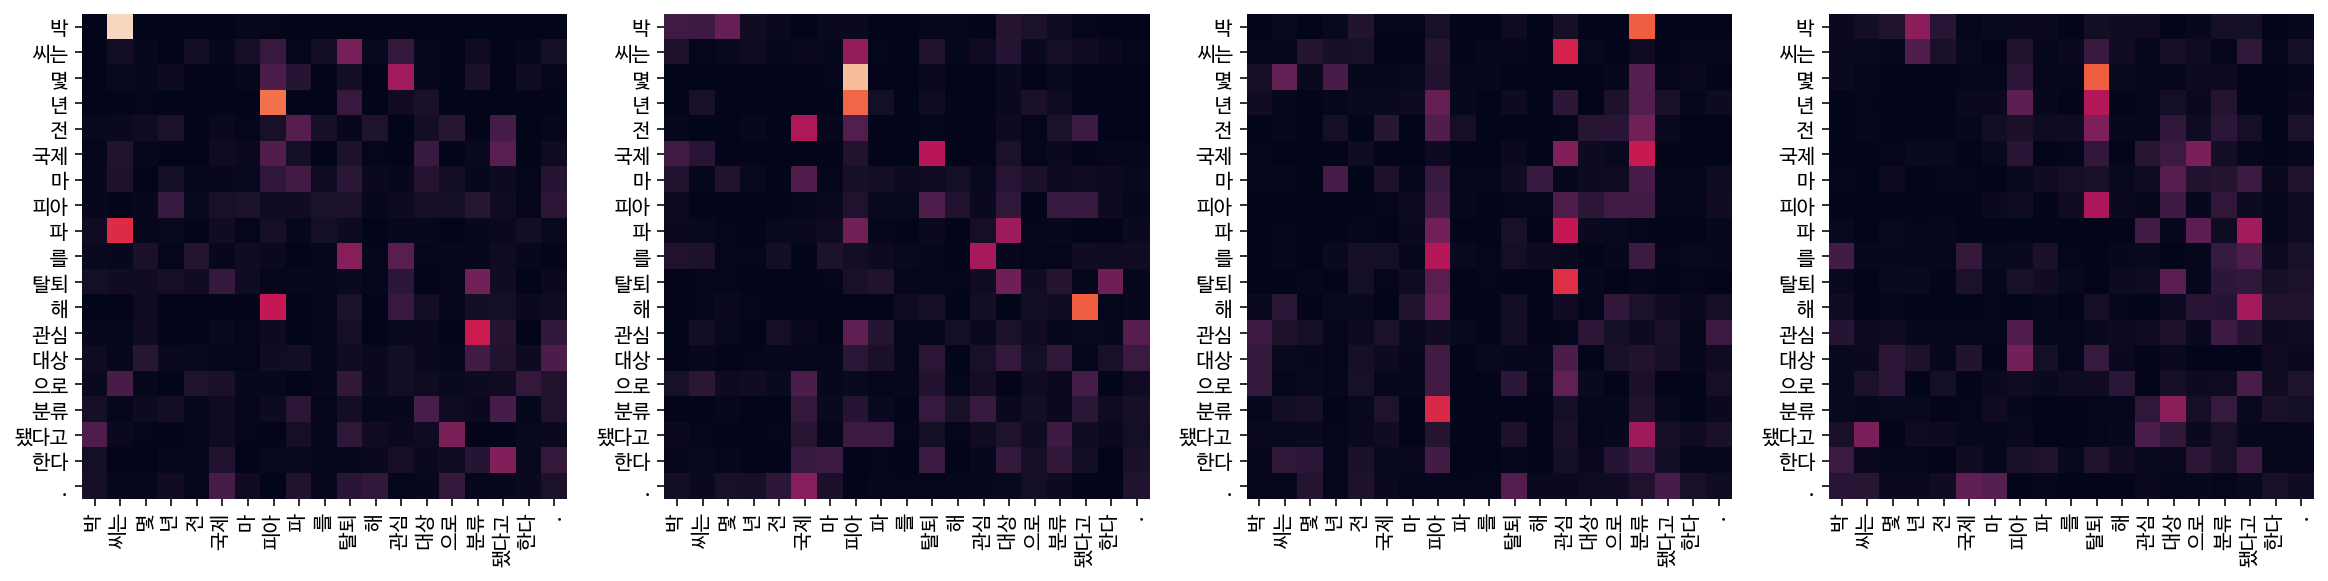

Encoder Layer 2


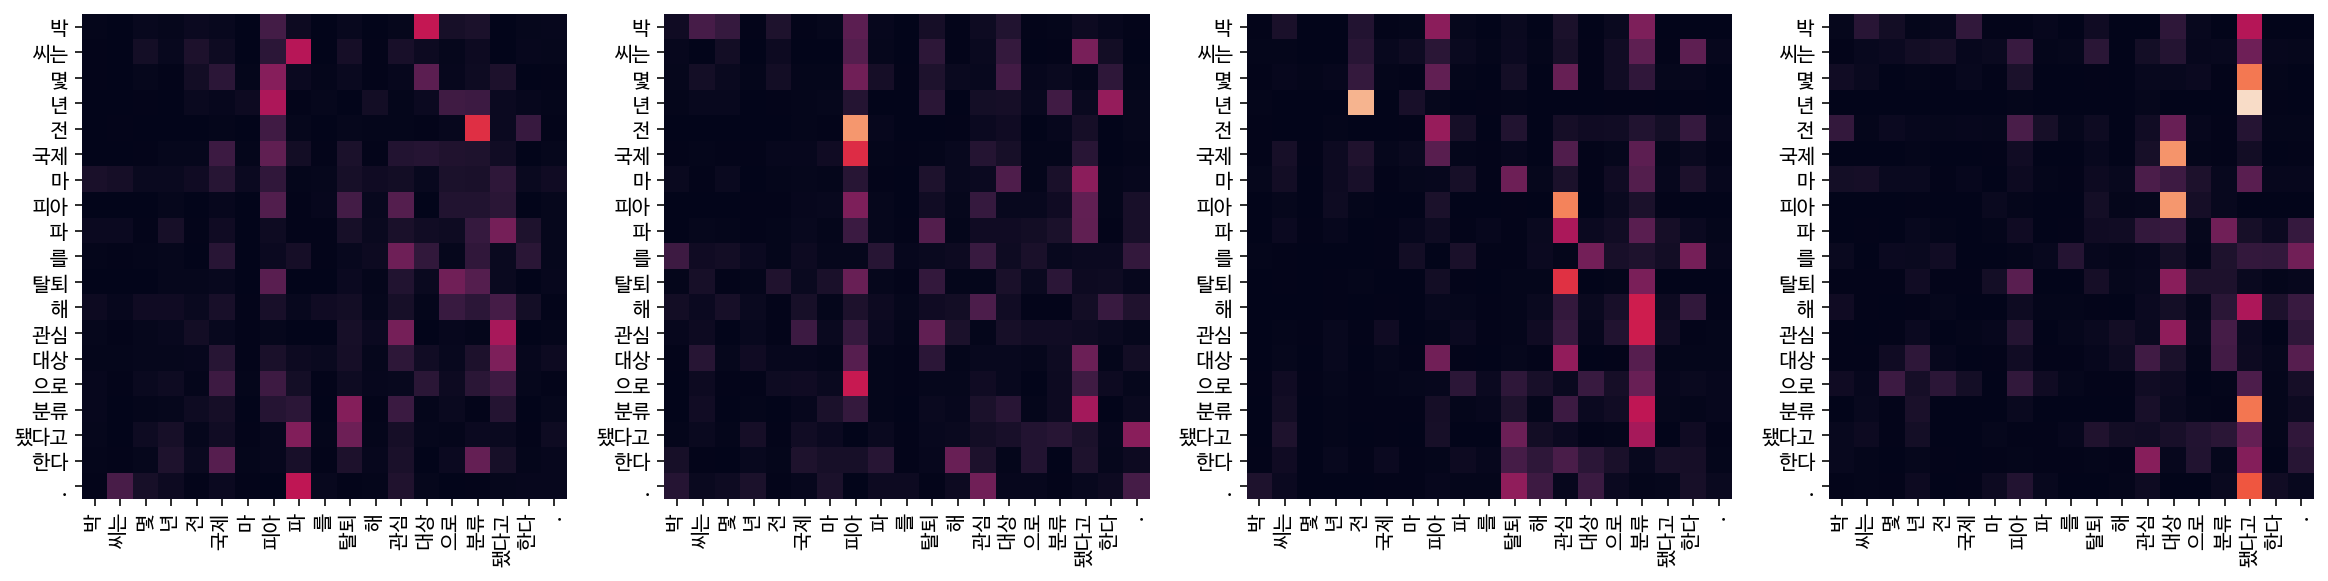

Decoder Self Layer 1


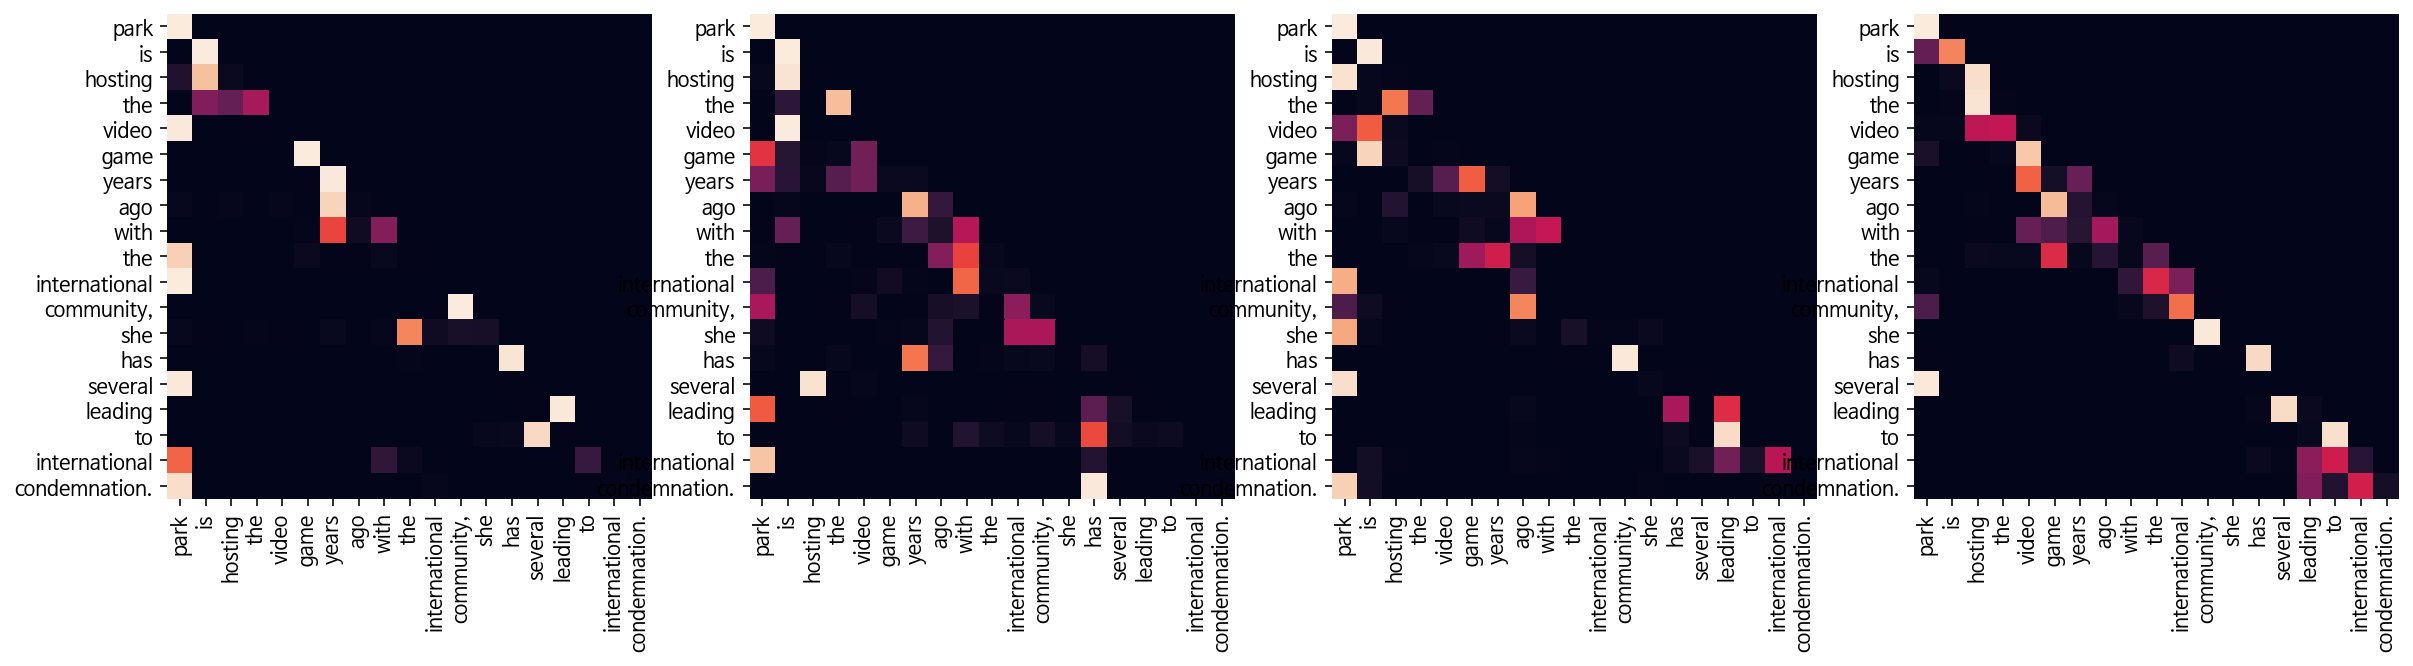

Decoder Src Layer 1


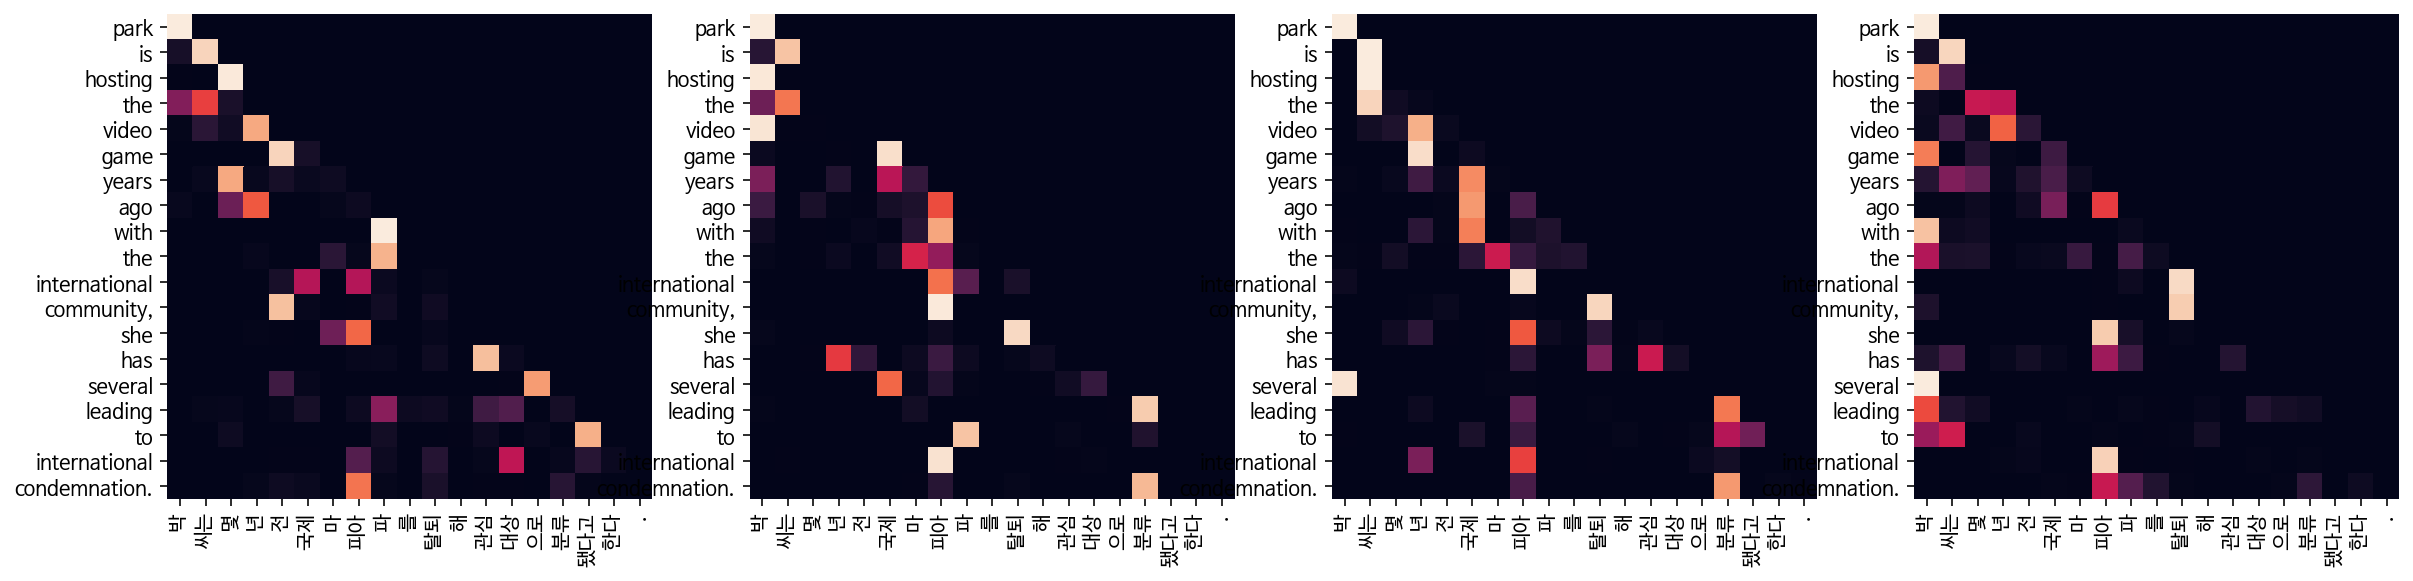

Decoder Self Layer 2


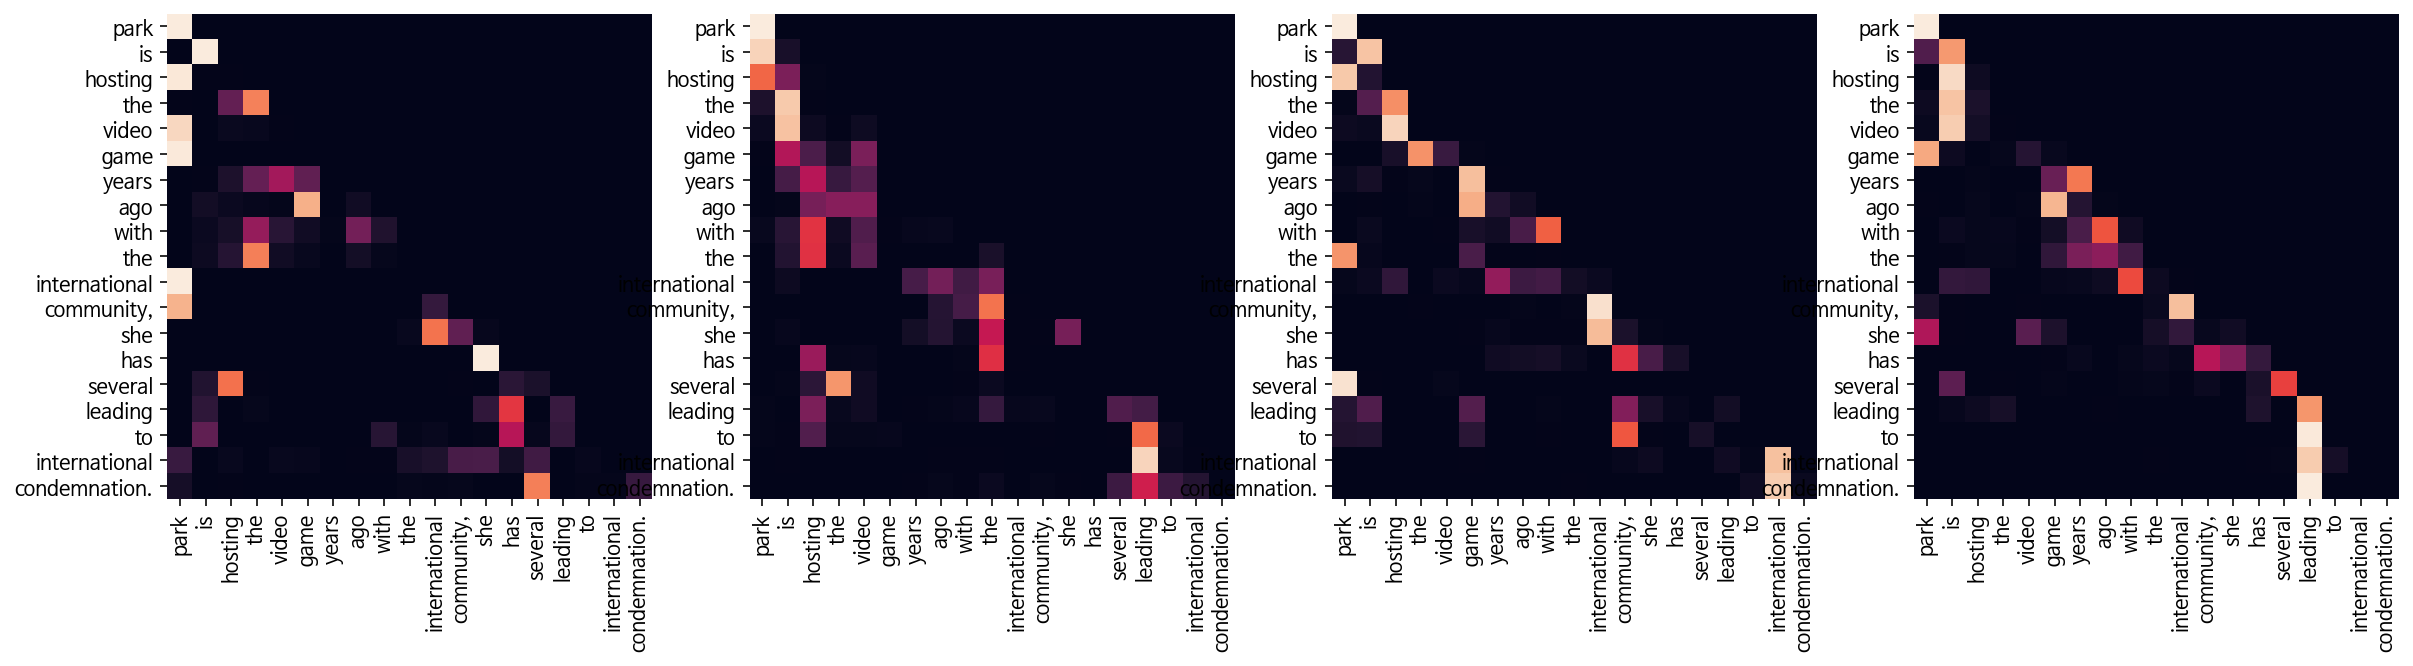

Decoder Src Layer 2


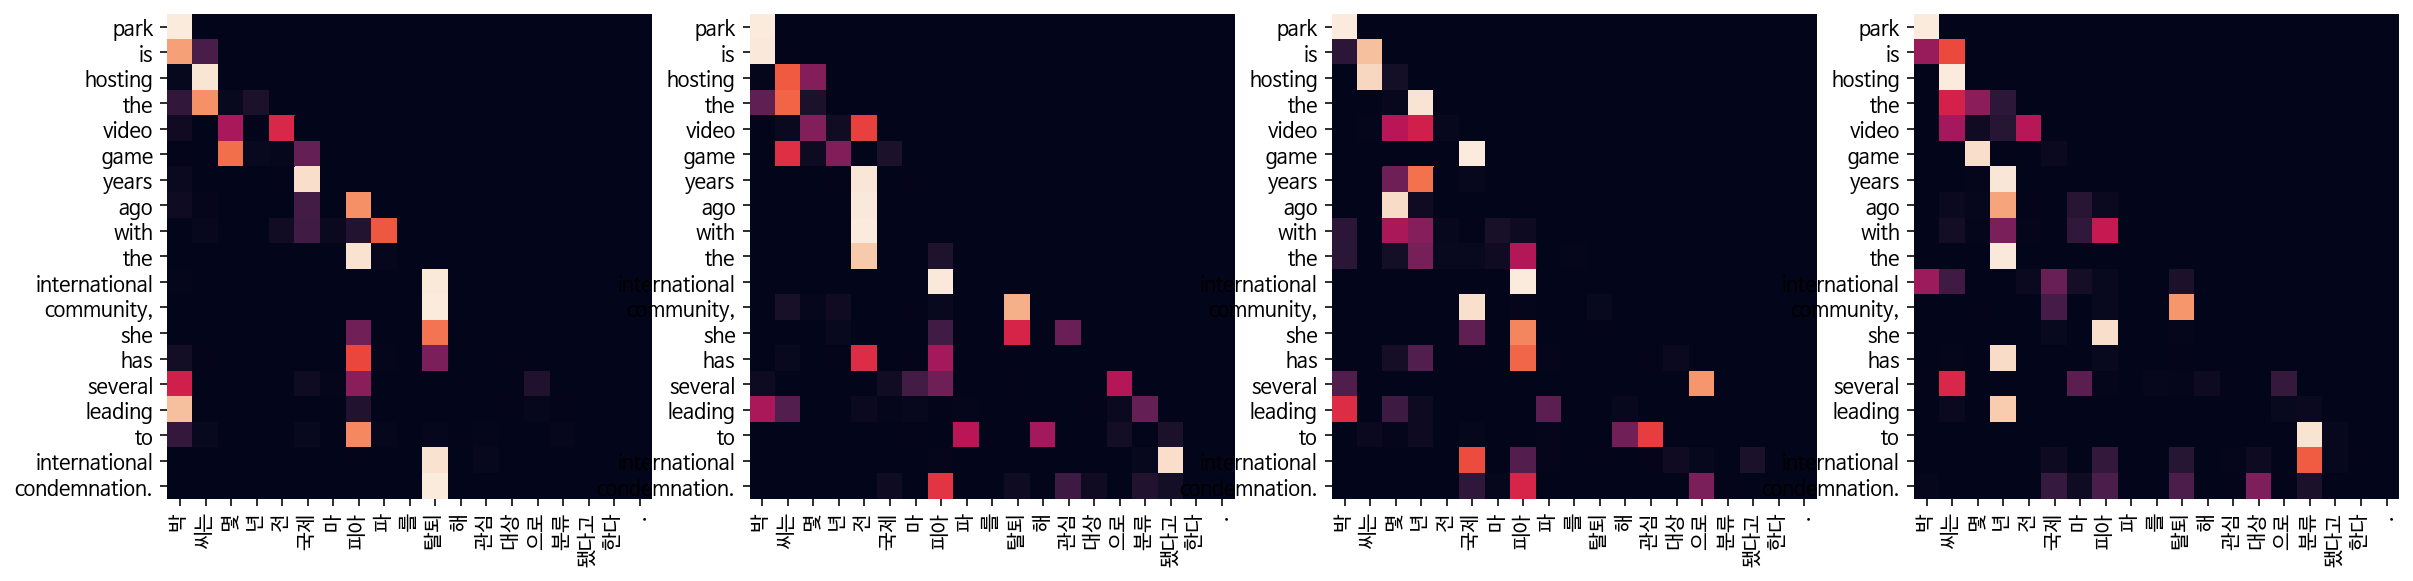

In [36]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다.",
            "투표는 시민의 권리이다",
            "음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.",
            "친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.",
            "박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
    
    if epoch == EPOCHS -1 : translate(example, transformer, ko_tokenizer, en_tokenizer, True)
        


# 4. 결과
### Translations
1. 오바마는 대통령이다. 
    > Predicted translation: obama is president.
2. 시민들은 도시 속에 산다. 
    > Predicted translation: citizens part of the san corporate
3. 커피는 필요 없다. 
    > Predicted translation: there s no need to be adopted.
4. 일곱 명의 사망자가 발생했다. 
    > Predicted translation: seven people were killed on saturday.
5. 투표는 시민의 권리이다. 
    > Predicted translation: the only voted a rights.
6. 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다. 
    > Predicted translation: the health care consists of million people over the last decade, as most of which is forecast of the way of last frontier guangdong university.
7. 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다. 
    > Predicted translation: instead, the energy efficient talkings now used his administration to remove itself of energy principles, like the goal of a first round of energy.
8. 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다. 
    > Predicted translation: park had a leading mass posts in the international community, park free former soviet

### Hyperparameters
- n_layers: 2
- d_model: 512
- n_heads: 8
- d_ff: 2048
- dropout: 0.2

### Training Parameters
- Warmup Steps: 4000
- Batch Size: 64
- Epoch At: 19

- 2개의 층만 쌓은 Transformer의 결과는 한국어 문장을 영어 문장으로 완벽히 번역해내지는 못했지만, 문법적으로 왠만큼 잘 들어맞으며 P04에서 실습한 BahdanauAttention model(n_layers: 2, d_model: 512, Batch Size: 64, Epoch At: 10)에 비해 문맥에 어울리는 번역을 해내는 것을 확인할 수 있습니다.
- 논문에서는 인코더와 디코더를 각각 6개를 사용하기 때문에, n_layers를 늘리면 성능이 향상될 것으로 짐작됩니다. 또한 훈련 시간을 줄이기 위해, 토큰의 길이를 임의로 50으로 제한했지만, 길이분포를 분석하여 적절한 토큰 길이를 파악할 수 있습니다. 